In [1]:
from firedrake import (
    RectangleMesh,
    FunctionSpace,
    Function,
    SpatialCoordinate,
    conditional,
    File,
)

In [2]:
from firedrake import *
# from firedrake_adjoint import *
import spyro
import numpy as np
import math

In [3]:
model = {}

# Choose method and parameters
model["opts"] = {
    "method": "KMV",  # either CG or KMV
    "quadratrue": "KMV", # Equi or KMV
    "degree": 1,  # p order
    "dimension": 2,  # dimension
}

# Number of cores for the shot. For simplicity, we keep things serial.
# spyro however supports both spatial parallelism and "shot" parallelism.
model["parallelism"] = {
    "type": "off",  # options: automatic (same number of cores for evey processor), custom, off.
    "custom_cores_per_shot": [],  # only if the user wants a different number of cores for every shot.
    # input is a list of integers with the length of the number of shots.
}

# Define the domain size without the PML. Here we'll assume a 0.75 x 1.50 km
# domain and reserve the remaining 250 m for the Perfectly Matched Layer (PML) to absorb
# outgoing waves on three sides (eg., -z, +-x sides) of the domain.
model["mesh"] = {
    "Lz": 0.75,  # depth in km - always positive
    "Lx": 1.5,  # width in km - always positive
    "Ly": 0.0,  # thickness in km - always positive
    "meshfile": "not_used.msh",
    "initmodel": "not_used.hdf5",
    "truemodel": "not_used.hdf5",
}

# Specify a 250-m PML on the three sides of the domain to damp outgoing waves.
model["PML"] = {
    "status": False,  # True or false
    "outer_bc": "non-reflective",  #  None or non-reflective (outer boundary condition)
    "damping_type": "polynomial",  # polynomial, hyperbolic, shifted_hyperbolic
    "exponent": 2,  # damping layer has a exponent variation
    "cmax": 4.7,  # maximum acoustic wave velocity in PML - km/s
    "R": 1e-6,  # theoretical reflection coefficient
    "lz": 0.25,  # thickness of the PML in the z-direction (km) - always positive
    "lx": 0.25,  # thickness of the PML in the x-direction (km) - always positive
    "ly": 0.0,  # thickness of the PML in the y-direction (km) - always positive
}

# Create a source injection operator. Here we use a single source with a
# Ricker wavelet that has a peak frequency of 8 Hz injected at the center of the mesh.
# We also specify to record the solution at 101 microphones near the top of the domain.
# This transect of receivers is created with the helper function `create_transect`.
model["acquisition"] = {
    "source_type": "Ricker",
    "num_sources": 1,
    "source_pos": [(0.1, 0.5)],
    "frequency": 3.0,
    "delay": 1.0,
    "num_receivers": 100,
    "receiver_locations": spyro.create_transect(
        (0.10, 0.1), (0.10, 0.9), 100
    ),
}

# Simulate for 2.0 seconds.
model["timeaxis"] = {
    "t0": 0.0,  #  Initial time for event
    "tf": 1.00,  # Final time for event
    "dt": 0.001,  # timestep size
    "amplitude": 1,  # the Ricker has an amplitude of 1.
    "nspool": 100,  # how frequently to output solution to pvds
    "fspool": 1,  # how frequently to save solution to RAM
}




In [4]:
mesh = RectangleMesh(100, 100, 1.0, 1.0)
# V    = FunctionSpace(mesh, family='CG', degree=2)
# Create the computational environment
comm = spyro.utils.mpi_init(model)

element = spyro.domains.space.FE_method(
    mesh, model["opts"]["method"], model["opts"]["degree"]
)
V = FunctionSpace(mesh, element)


In [5]:
x, y = SpatialCoordinate(mesh)
velocity = conditional(x > 0.35, 1.5, 3.0)

vp = Function(V, name="vp").interpolate(velocity)

# These pvd files can be easily visualized in ParaView!
File("simple_velocity_model.pvd").write(vp)

velocity0 = conditional(x > 0.35, 1, 1.0)
vp_guess = Function(V, name="control").interpolate(velocity0)


In [6]:
bcval = Constant(0.0)
def delta_expr(x0, z, xm, sigma_x):
    
    return exp(-sigma_x * ((z - x0[0]) ** 2 + (x - x0[1]) ** 2))

def timedependentSource(model, t, freq=None, amp=1, delay=1.5):
    if model["acquisition"]["source_type"] == "Ricker":
        return RickerWavelet(t, freq, amp, delay=delay)
    elif model["acquisition"]["source_type"] == "MMS":
        return MMS_time(t)
    else:
        raise ValueError("source not implemented")


def RickerWavelet(t, freq, amp=1.0, delay=1.5):
    """Creates a Ricker source function with a
    delay in term of multiples of the distance
    between the minimums.
    """
    t = t - delay * math.sqrt(6.0) / (math.pi * freq)
    return (
        amp
        * (1.0 - (1.0 / 2.0) * (2.0 * math.pi * freq) * (2.0 * math.pi * freq) * t * t)
        * math.exp(
            (-1.0 / 4.0) * (2.0 * math.pi * freq) * (2.0 * math.pi * freq) * t * t
        )
    )


def FullRickerWavelet(dt, tf, freq, amp=1.0, cutoff=None):
    """Compute the full Ricker wavelet and apply low-pass filtering
    using cutoff frequency in hz
    """
    nt = int(tf / dt)  # number of timesteps
    time = 0.0
    FullWavelet = np.zeros((nt,))
    for t in range(nt):
        FullWavelet[t] = RickerWavelet(time, freq, amp)
        time += dt
    if cutoff is not None:
        fs = 1.0 / dt
        order = 2
        nyq = 0.5 * fs  # Nyquist Frequency
        normal_cutoff = cutoff / nyq
        # Get the filter coefficients
        b, a = butter(order, normal_cutoff, btype="low", analog=False)
        FullWavelet = filtfilt(b, a, FullWavelet)
    return FullWavelet


In [7]:
dim    = 2
amp    = 1
freq   = model["acquisition"]["frequency"]
method = model["opts"]["method"]
degree = model["opts"]["degree"]
dt     = model["timeaxis"]["dt"]
tf     = model["timeaxis"]["tf"]
delay  = model["acquisition"]["delay"]
nspool = model["timeaxis"]["nspool"]
fspool = model["timeaxis"]["fspool"]
params = {"ksp_type": "preonly", "pc_type": "jacobi"}
# params = {"ksp_type": "cg", "pc_type": "jacobi"}

qr_x, qr_s, _ = spyro.domains.quadrature.quadrature_rules(V)

source_num = 0

receivers = spyro.Receivers(model, mesh, V, comm).create()

In [8]:

from firedrake.assemble import create_assembly_callable
set_log_level(ERROR)

sigma_x = Constant(2000)
nt = int(tf / dt)  # number of timesteps
dstep = int(delay / dt)  # number of timesteps with source

if method == "KMV":
    params = {"ksp_type": "preonly", "pc_type": "jacobi"}
elif method == "CG":
    params = {"ksp_type": "cg", "pc_type": "jacobi"}
else:
    raise ValueError("method is not yet supported")

element = spyro.domains.space.FE_method(mesh, method, degree)

V  = FunctionSpace(mesh, element)

qr_x, qr_s, _ = spyro.domains.quadrature.quadrature_rules(V)

z, x = SpatialCoordinate(mesh)

u = TrialFunction(V)
v = TestFunction(V)

u_nm1 = Function(V)
u_n = Function(V)
u_np1 = Function(V)

is_local = spyro.solvers.helpers.receivers_local(mesh, dim, receivers.receiver_locations)

t = 0.0
usol_recv = []
RW = FullRickerWavelet(dt, tf, freq, amp=amp, cutoff=None)


pos = model["acquisition"]["source_pos"]

source = Constant(pos[source_num])
delta = Interpolator(delta_expr(source, z, x, sigma_x), V)
excitation = Function(delta.interpolate())

ricker = Constant(0)
f = excitation * ricker
ricker.assign(RW[0], annotate=True)

# -------------------------------------------------------
m1 = ((u - 2.0 * u_n + u_nm1) / Constant(dt ** 2)) * v * dx(rule=qr_x)
a = vp * vp * dot(grad(u_n), grad(v)) * dx(rule=qr_x)  # explicit

nf = 0

FF = m1 + a + nf - f * v * dx(rule=qr_x)

X = Function(V)
B = Function(V)

lhs_ = lhs(FF)
rhs_ = rhs(FF)
#----------------------------------------------------
A      = assemble(lhs_)
solver = LinearSolver(A, solver_parameters=params)
#----------------------------------------------------
saveIT = 0
usol = [Function(V, name="pressure") for t in range(nt) if t % fspool == 0]

assembly_callable = create_assembly_callable(rhs_, tensor=B)
obj = 0
for IT in range(nt):

    if IT < dstep:
        ricker.assign(RW[IT], annotate=True)
    elif IT == dstep:
        ricker.assign(0.0, annotate=True)

    assembly_callable()

    solver.solve(X, B)

    u_np1.assign(X)
    u_nm1.assign(u_n)
    u_n.assign(u_np1)

    usol_recv.append(receivers.interpolate(u_n.dat.data_ro_with_halos[:], is_local))
    if IT % fspool == 0:
        usol[saveIT].assign(u_n,annotate=True)
        saveIT += 1
usol_recv = spyro.solvers.helpers.fill(usol_recv, is_local, nt, receivers.num_receivers)
usol_recv = spyro.utils.communicate(usol_recv, comm)


100


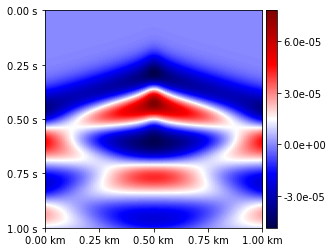

In [9]:
import numpy                  as np
import matplotlib.pyplot      as plot
import matplotlib.ticker      as mticker  
from matplotlib               import cm
from mpl_toolkits.axes_grid1  import make_axes_locatable
from matplotlib               import ticker
def graph2drec(rec):  
    print(len(rec[0]))
    
    tf     = model["timeaxis"]["tf"]
    extent = [0,1, tf, 0]
    fig    = plot.imshow(rec[:][:], cmap="seismic", extent=extent)
    plot.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f km'))
    plot.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f s'))
    ax = plot.gca()
    ax.xaxis.set_major_locator(plot.MaxNLocator(4))
    ax.yaxis.set_major_locator(plot.MaxNLocator(4))
    
    divider = make_axes_locatable(ax)
    
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    tick_locator = ticker.MaxNLocator(nbins=5)
    
    cbar = plot.colorbar(fig, cax=cax, format='%.1e')
    
    cbar.locator = tick_locator
    
    cbar.update_ticks()
    
    plot.draw()
     
    plot.show()
    plot.close()

    return
#==============================================================================

graph2drec(usol_recv)

In [10]:
misfit = spyro.utils.evaluate_misfit(
                        model, comm, 2*usol_recv, usol_recv
                    )

J_total = spyro.utils.compute_functional(model, comm, misfit)




Computing the misfit...
Computing the functional...
[2.106241538493023e-21, 2.1288969248898558e-20, 9.786020696683416e-20, 3.074359973322761e-19, 7.66870742371112e-19, 1.6358573005614064e-18, 3.1150103206535065e-18, 5.4419680656101364e-18, 8.887233922003988e-18, 1.3751207626897074e-17, 2.0363325744728965e-17, 2.9083658566964854e-17, 4.0306855359190453e-17, 5.446806266431036e-17, 7.205035672285479e-17, 9.359328364641709e-17, 1.1970223068683562e-16, 1.5105850723285894e-16, 1.8843015845614727e-16, 2.326836466321299e-16, 2.84796607168365e-16, 3.45871920948852e-16, 4.1715335183459693e-16, 5.000429917820078e-16, 5.961207494347851e-16, 7.071661209388783e-16, 8.351824984379872e-16, 9.824243012616695e-16, 1.1514272526776473e-15, 1.3450421656362051e-15, 1.566472639908197e-15, 1.8193171090003924e-15, 2.1076157100054e-15, 2.43590248724585e-15, 2.809263486126316e-15, 3.2334013510283514e-15, 3.714707112269379e-15, 4.2603399315170814e-15, 4.878315670145385e-15, 5.577605247768921e-15, 6.36824386643582

In [11]:
from scipy.sparse import csc_matrix

def _adjoint_update_rhs(rhs_forcing, excitations, residual, IT, is_local):
    """Builds assembled forcing function f for adjoint for a given time_step
    given a number of receivers
    """
    recs = [recv for recv in range(excitations.shape[1]) if is_local[recv]]
    rhs_forcing.dat.data[:] = excitations[:, recs].dot(residual[IT][recs])

    return rhs_forcing


is_local = [mesh.locate_cell([z, x]) for z, x in receivers.receiver_locations]
dJdC_local = Function(V)
receiver = Constant([0, 0])

# receivers are forced through sparse matrix vec multiplication
sparse_excitations = csc_matrix((len(dJdC_local.dat.data), receivers.num_receivers))

for r, x0 in enumerate(receivers.receiver_locations):
    receiver.assign(x0)
    exct = delta.interpolate().dat.data_ro.copy()
    row = exct.nonzero()[0]
    col = np.repeat(r, len(row))
    sparse_exct = csc_matrix(
        (exct[row], (row, col)), shape=sparse_excitations.shape
    )
    sparse_excitations += sparse_exct

u = TrialFunction(V)
v = TestFunction(V)

u_nm1 = Function(V)
u_n = Function(V)
u_np1 = Function(V)

t = 0.0

# -------------------------------------------------------
m1 = ((u - 2.0 * u_n + u_nm1) / Constant(dt ** 2)) * v * dx(rule=qr_x)
a = vp * vp * dot(grad(u_n), grad(v)) * dx(rule=qr_x)  # explicit

FF = m1 + a 

X = Function(V)
B = Function(V)

lhs_ = lhs(FF)
rhs_ = rhs(FF)

A = assemble(lhs_, mat_type="matfree")
solver = LinearSolver(A, solver_parameters=params)

# Define gradient problem
g_u = TrialFunction(V)
g_v = TestFunction(V)

mgrad = g_u * g_v * dx(rule=qr_x)


uuadj = Function(V)  # auxiliarly function for the gradient compt.
uufor = Function(V)  # auxiliarly function for the gradient compt.

ffG = 2.0 * vp * Constant(dt) * dot(grad(uuadj), grad(uufor)) * g_v * dx(rule=qr_x)

G = mgrad - ffG
lhsG, rhsG = lhs(G), rhs(G)

gradi = Function(V)
grad_prob = LinearVariationalProblem(lhsG, rhsG, gradi)

grad_solv = LinearVariationalSolver(
            grad_prob,
            solver_parameters={
                "ksp_type": "preonly",
                "pc_type": "jacobi",
                "mat_type": "matfree",
            },
        )
assembly_callable = create_assembly_callable(rhs_, tensor=B)

rhs_forcing = Function(V)  # forcing term

for IT in range(nt - 1, -1, -1):
    t = IT * float(dt)

    # Solver - main equation - (I)
    # B = assemble(rhs_, tensor=B)
    assembly_callable()

    f = _adjoint_update_rhs(rhs_forcing, sparse_excitations, misfit, IT, is_local)
    # add forcing term to solve scalar pressure
    B.sub(0).dat.data[:] += f.dat.data[:]

    # AX=B --> solve for X = B/Aˆ-1
    solver.solve(X, B)
    
    u_np1.assign(X)
    u_nm1.assign(u_n)
    u_n.assign(u_np1)

    # compute the gradient increment
    uuadj.assign(u_n)

    # only compute for snaps that were saved
    if IT % fspool == 0:
        gradi.assign = 0.0
        uufor.assign(usol.pop())

        grad_solv.solve()
        dJdC_local += gradi

    if IT % nspool == 0:
        # if output:
        #    outfile.write(u_n, time=t)
        spyro.solvers.helpers.display_progress(comm, t)



Simulation time is:        0.9 seconds
Simulation time is:        0.8 seconds
Simulation time is:        0.7 seconds
Simulation time is:        0.6 seconds
Simulation time is:        0.5 seconds
Simulation time is:        0.4 seconds
Simulation time is:        0.3 seconds
Simulation time is:        0.2 seconds
Simulation time is:        0.1 seconds
Simulation time is:        0.0 seconds


In [12]:
from mpi4py import MPI
# sum over all ensemble members
dJdC_local.dat.data[:] = comm.ensemble_comm.allreduce(
    dJdC_local.dat.data[:], op=MPI.SUM
)

print(J_total)
File("grad.pvd").write(dJdC_local)

4.331474955186621e-06
